In [1]:
%load_ext autoreload
%autoreload 2

## Check GPU 

In [29]:
from tensorflow.python.client import device_lib


[x for x in device_lib.list_local_devices() if x.device_type == 'GPU']

[]

## Clone github repository

In [30]:
! git clone https://github.com/nabacg/aml-nlp-notes.git

Cloning into 'aml-nlp-notes'...
remote: Enumerating objects: 140, done.
remote: Counting objects: 100% (140/140), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 140 (delta 66), reused 110 (delta 38), pack-reused 0
Receiving objects: 100% (140/140), 8.91 MiB | 5.57 MiB/s, done.
Resolving deltas: 100% (66/66), done.


In [ ]:
import os 
print(os.getcwd())
[n for n in dir(os) if 'ch' in n]
os.chdir('/content/aml-nlp-notes/language-model')
print(os.getcwd())

## Download data files

## cornell dataset

In [ ]:
! sh download_cornell.sh

## Imports required

In [85]:
import tensorflow as tf
import os
from seq2seqdataprocessing import load_dataset, word_to_idx
from sklearn.model_selection import train_test_split
from language_model import Encoder, Decoder, train_model, gen_answer, create_bot, load_embeddings 


1.13.1


## Hyperparameters

In [65]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 128
N_BATCH = BUFFER_SIZE//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_size = 23106 # why 23106 ? because that covers ~99% of vocabulary for Cornell
max_length = 40

## Prepare train, test dataset

In [66]:
dataset_name = 'cornell'
input_tensor, target_tensor, dict_index = load_dataset(dataset_name = dataset_name, 
                                                       max_sentence_length=max_length, 
                                                       vocab_size=vocab_size) 

word2idx = dict_index[0]

# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.1)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

100%|██████████| 83097/83097 [00:04<00:00, 17815.13it/s]


(71517, 71517, 7947, 7947)

In [67]:
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

## Create encoder, decoder instance

In [68]:
embedding, embedding_dim, emb_matrix  = load_embeddings('data/starspace_embeddings.tsv', word2idx)

Filling pre-trained embeddings...


In [69]:
# https://stackoverflow.com/a/52566623
# https://github.com/tensorflow/tensorflow/issues/14392

pretrained_emb = tf.keras.layers.Embedding(vocab_size, embedding_dim, 
                                           embeddings_initializer = tf.initializers.constant(emb_matrix),
                                           trainable=False)

In [70]:
encoder = Encoder(vocab_size, embedding_dim, units, BATCH_SIZE, pretrained_emb)
decoder = Decoder(vocab_size, embedding_dim, units, BATCH_SIZE, pretrained_emb)
optimizer = tf.train.AdamOptimizer()

## Mount Google drive to save model checkpoints

In [ ]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

## Checkpoints 

In [95]:
checkpoint_dir = './cornell-40'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

### Set checkpoint for Google drive 

In [ ]:
checkpoint_dir = "/content/drive/My Drive/cornell-ds-training"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## Local checkpoint

In [61]:
checkpoint_dir = "/Users/cab/Dev/DeepLearning/Coursera/aml_spec/nlp/language-model/14-pre-emb-15-20190709T183102Z-001"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

#### Checkpoint Manager
https://www.tensorflow.org/beta/guide/checkpoints?hl=en

In [96]:
manager = tf.train.CheckpointManager(checkpoint, "./cornell-40", 
                                     max_to_keep=3)

In [99]:
tf.train.latest_checkpoint(checkpoint_dir)

'./cornell-40/ckpt-25'

In [110]:
manager.latest_checkpoint

### Restore previous checkpoints 

In [111]:
checkpoint.restore(manager.latest_checkpoint)

In [112]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [46]:
# restoring specific checkpoint in checkpoint_dir
checkpoint.restore(
    '/Users/cab/Dev/DeepLearning/Coursera/aml_spec/nlp/language-model/14-pre-emb-15-20190709T183102Z-001/ckpt-24')

## Training 

In [ ]:
train_model(encoder, 
            decoder, 
            optimizer,
            dataset, 
            BATCH_SIZE, 
            N_BATCH,
            start_word_index=word_to_idx(word2idx, '<start>'),
            epochs=3,
            save_checkpoint=lambda: manager.save())

## Evaluation

Input: <start> hi <end>
Answer: shhhhh epps pussywillows extanker cocksucker false rangers meanwith dilophosaurus reputation hmmm swell trunk fastest pocketbook 


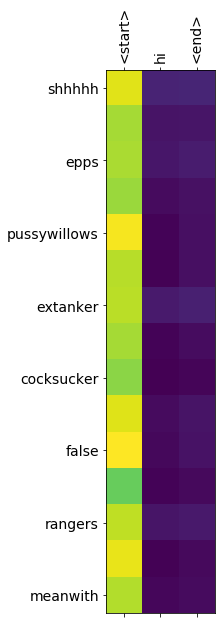

'shhhhh epps pussywillows extanker cocksucker false rangers meanwith dilophosaurus reputation hmmm swell trunk fastest pocketbook '

In [113]:
gen_answer("Hi", encoder, decoder, dict_index, units, max_length=15, print_debug=True)

In [118]:
answer = create_bot(encoder, decoder, dict_index, units, 10)

In [119]:
answer("hi")

'shhhhh epps pussywillows extanker cocksucker false rangers meanwith dilophosaurus proposal '

In [90]:
qs = ['Hey',
      "What is your name?",
 'How are you doing?',
 "What's your hobby?",
 "Where are you now?",
 "Which city do you live in?",
 "Which country do you live in?",
 "Which country do you live in now?",
 'What is an AI?',
 'What is the meaning of life?']

In [117]:
for q in qs:
    print("q: ", q)
    print("a: ", answer(q))

q:  Hey
a:  shhhhh fortytwohundred hips spose dreyfuss burgel telephone nellie dickweed shoulders mmmmmm jest uhmaybe proposal sewers napkin oskar whatta mentor across rosalie despite burgers sonnyboy barbie mmmhmmm shhhh apollo whata choices emotional ace nellie dickweed shoulders mmmmmm jest uhmaybe proposal sewers 
q:  What is your name?
a:  shhhhh fortytwohundred hips spose dreyfuss jodys valet hitchhiking transmits eliminate dilophosaurus reputation hmmm swell trunk fastest pocketbook bollocks yaay reputation hmmm swell trunk fastest pocketbook bollocks yaay reputation hmmm swell trunk fastest pocketbook bollocks yaay reputation hmmm swell trunk fastest 
q:  How are you doing?
a:  cotton och iare contract shoulders mmmmmm jest uhmaybe proposal sewers reputation hmmm swell trunk fastest pocketbook bollocks wellnot fraid oharoundwhy extanker cocksucker false rangers roommate thumper oskar whatta restaurant uhmaybe proposal sewers reputation hmmm swell trunk fastest pocketbook bolloc